# Lyft Dataset Analysis

This project explores Lyft bike data, which I will analyse to gain insights into trends and information regarding bike demand. I will use Python to analyse the dataset with the use of pandas, NumPy, and Matplotlib to help answer the questions below.

The main questions I will be looking to answer using our dataset include:
* What are common trends among the dataset regarding:
    * Time of day
    * Day of week
    * Month
    * Season
* Are there different habits between casual and registered users?
* How does weather influence demand?
* Can we predict demand based on temperature? 



### Import Libraries 

In [74]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt 

### Importing and viewing data

In [6]:
lyft_data = pd.read_csv("Lyftdataset.csv")
lyft_data.head()

,instant,date,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,cnt
0,1,01.01.2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01.01.2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01.01.2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01.01.2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01.01.2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


This dataset includes 17 columns, and 17,379 rows of data containing information about Lyft bike sharing services.

Here is a summary of all the columns: 

* __Instant:__ index values for csv
* __Date:__ date of recorded values
* __Season:__ seasons (1 = spring, 2 = summer, 3 = fall, 4 = winter)
* __Year:__ year of recorded data (0 = 2011, 1 = 2012)
* __Month:__ month of recorded values
* __Hour:__ hour which the order was place
* __Holiday:__ whether the day was holiday or not
* __Weekday:__ day of the week
* __Workingday:__ whether day was work day(1) (Mon-Fri) or not (0)
* __Weathersit:__ situation of the weather (1 = clear, 2 = cloudy, 3 = light rain, 4 = heavy rain) 
* __Temp:__ normalized temperature in celsius with values divided by 41 (max)
* __Atemp:__ normalized felt temperature in celsius with values divided by 50 (max)
* __Humidity:__ normalized humidity with values divided by 100 (max)
* __Windspeed:__ normalized wind speed with values divided by 67 (max)
* __Casual:__ count of bikes demanded for causual users using Lyft
* __Registered:__ count of bikes demanded for registered users using Lyft
* __Cnt:__ Total count of demand for bikes (casual + registered)


In [9]:
print(lyft_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  int64  
 3   year        17379 non-null  int64  
 4   month       17379 non-null  int64  
 5   hour        17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  humidity    17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


### Data Cleaning

I have decided to drop multiple columns from our dataset to help reduce complexity and improve regression performance.

I have dropped the columns titled: 
* "instant" only provided a index number from original csv file
* "humidity" to reduce noise during analysis and predictions and for easier interpretation of data
* "windspeed" to reduce noise during analysis and predictions and for easier interpretation of data

  

In [12]:
drop_columns = ["instant", "humidity", "windspeed", "workingday"]
lyft_data = lyft_data.drop(drop_columns, axis=1 )

In [13]:
lyft_data.head()

,date,season,year,month,hour,holiday,weekday,weathersit,temp,atemp,casual,registered,cnt
0,01.01.2011,1,0,1,0,0,6,1,0.24,0.2879,3,13,16
1,01.01.2011,1,0,1,1,0,6,1,0.22,0.2727,8,32,40
2,01.01.2011,1,0,1,2,0,6,1,0.22,0.2727,5,27,32
3,01.01.2011,1,0,1,3,0,6,1,0.24,0.2879,3,10,13
4,01.01.2011,1,0,1,4,0,6,1,0.24,0.2879,0,1,1


Below, I have switched the numerical values of the columns season and weekday to help improve the readability of the dataset

In [16]:
weekday_mapping = {0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"}
lyft_data["weekday"] = lyft_data["weekday"].map(weekday_mapping)

season_mapping = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
lyft_data["season"] = lyft_data["season"].map(season_mapping)

## Initial Exploration

In [18]:
lyft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        17379 non-null  object 
 1   season      17379 non-null  object 
 2   year        17379 non-null  int64  
 3   month       17379 non-null  int64  
 4   hour        17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  object 
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  casual      17379 non-null  int64  
 11  registered  17379 non-null  int64  
 12  cnt         17379 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.7+ MB


In [88]:
lyft_data.head()

,date,season,year,month,hour,holiday,weekday,weathersit,temp,atemp,casual,registered,cnt
0,01.01.2011,Spring,0,1,0,0,Saturday,1,0.24,0.2879,3,13,16
1,01.01.2011,Spring,0,1,1,0,Saturday,1,0.22,0.2727,8,32,40
2,01.01.2011,Spring,0,1,2,0,Saturday,1,0.22,0.2727,5,27,32
3,01.01.2011,Spring,0,1,3,0,Saturday,1,0.24,0.2879,3,10,13
4,01.01.2011,Spring,0,1,4,0,Saturday,1,0.24,0.2879,0,1,1


In [86]:
lyft_data.describe()

,year,month,hour,holiday,weathersit,temp,atemp,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,0.028770,1.425283,0.496987,0.475775,35.676218,153.786869,189.463088
std,0.500008,3.438776,6.914405,0.167165,0.639357,0.192556,0.171850,49.305030,151.357286,181.387599
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,0.000000,1.000000,0.340000,0.333300,4.000000,34.000000,40.000000
50%,1.000000,7.000000,12.000000,0.000000,1.000000,0.500000,0.484800,17.000000,115.000000,142.000000
75%,1.000000,10.000000,18.000000,0.000000,2.000000,0.660000,0.621200,48.000000,220.000000,281.000000
max,1.000000,12.000000,23.000000,1.000000,4.000000,1.000000,1.000000,367.000000,886.000000,977.000000


## What are common trends regarding:

### Hourly trends

In [21]:
avg_hourly_data = lyft_data.groupby("hour")["cnt"].mean()
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19 , 20, 21, 22, 23]

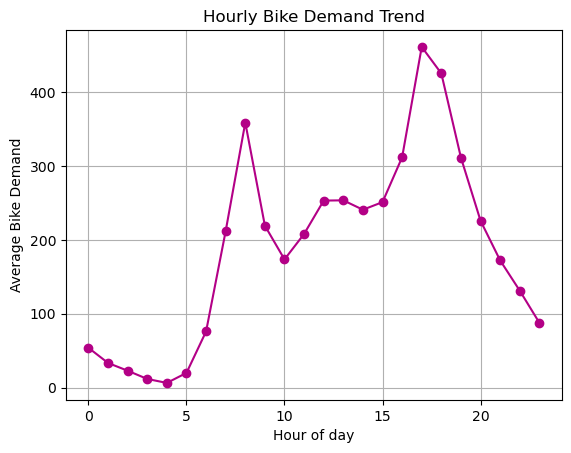

In [22]:
plt.plot(hours, avg_hourly_data, color="#B30086", marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Average Bike Demand")
plt.title("Hourly Bike Demand Trend")
plt.grid()

plt.show()

This graph shows the average hourly bike demand. We can deduce that the peak hours in demand for bikes occur at 7:00-9:00 and 17:00-18:00. At 8:00 we hit a peak of 358 bikes demanded. Following this peak, there is a slight decline down to 170 bikes demanded at 10:00, followed by a gradual increase till we hit another set of peak hours from 17:00-18:00, reaching a max of 460. The hour with the lowest demand occurs at 4:00 with an average of 6 bikes. Overall, from this graph, we can infer that these bikes are primarily used for commuting.

### Daily trends

In [25]:
avg_daily_data = lyft_data.groupby("weekday")["cnt"].mean()
day_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"] 
avg_daily_data_ordered = avg_daily_data.reindex(day_of_week)

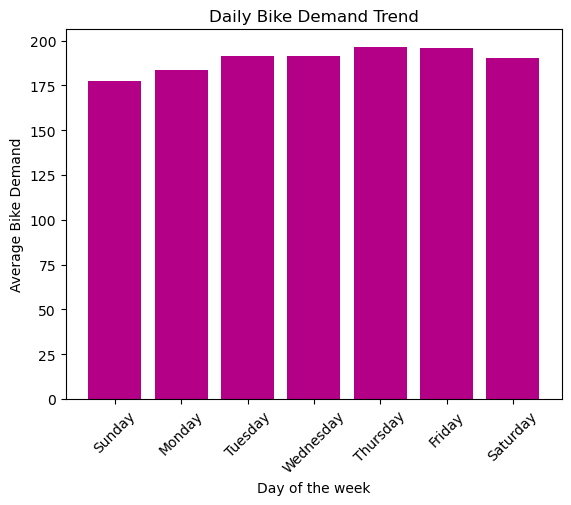

In [26]:
plt.bar(day_of_week, avg_daily_data_ordered, color="#B30086")
plt.xlabel("Day of the week")
plt.ylabel("Average Bike Demand")
plt.title("Daily Bike Demand Trend")
plt.xticks(rotation=45)

plt.show()

This graph gives us insight into the average demand of bikes for each day of the week. From this graph, it appears that there is a steady demand for bikes throughout the week, but we can see that the peak days of the week are Thursday and Friday, reaching averages of 196 bikes demanded, with the day with the lowest demand being on Sunday, with an average of 177.

### Monthly trends

In [29]:
avg_monthly_data = lyft_data.groupby("month")["cnt"].mean()
months = [ "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

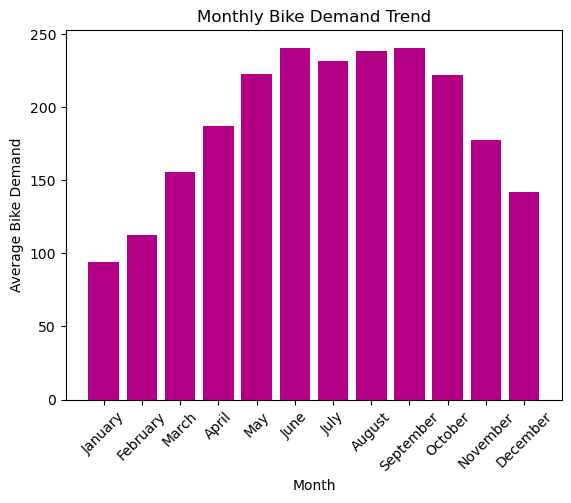

In [30]:
plt.bar(months, avg_monthly_data, color="#B30086")
plt.xlabel("Month")
plt.ylabel("Average Bike Demand")
plt.title("Monthly Bike Demand Trend")
plt.xticks(rotation=45)

plt.show()

This graph gives us insight into the average demand of bikes throughout the months of the year. From this graph, it appears that there is a peak in demand for spring and summer months starting in May ending in September. This is followed by a dip in demand during the winter months where we can suggest that due to weather condions weather may be unfavorable . 

### Seasonal trends

In [32]:
avg_season_data = lyft_data.groupby("season")["cnt"].mean()
name_seasons = ["Spring", "Summer", "Fall", "Winter"]
season_avg = [111.11, 208.34, 236.02, 198.87]

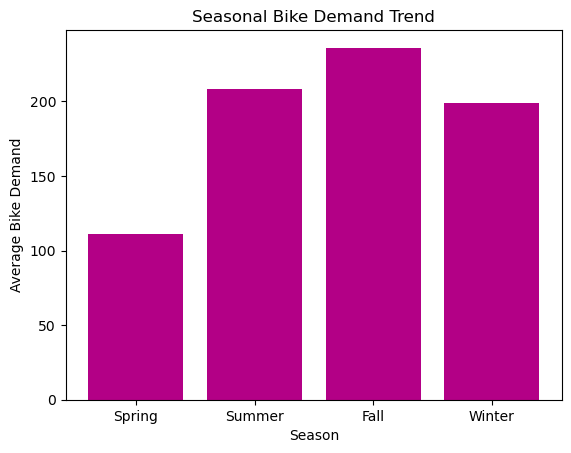

In [33]:
plt.bar(name_seasons, season_avg, color="#B30086")
plt.xlabel("Season")
plt.ylabel("Average Bike Demand")
plt.title("Seasonal Bike Demand Trend")

plt.show()

This graph shows seasonal bike rental demand. From this graph, we can see that spring has the lowest demand for bikes, with less than 800 bikes demanded during the spring of 2011 and 2012. Summer, Fall, and Winter exceed 900. Fall sees the highest demand, followed closely by Winter and Summer. Lyft can expect a fairly steady demand for most of the year but may face a potential decline in demand for bikes during the spring months.

## Registered vs Casual trends

In [36]:
# avg registered user demand
reg_hourly_data = lyft_data.groupby("hour")["registered"].mean()
reg_daily_data = lyft_data.groupby("weekday")["registered"].mean()
reg_monthly_data = lyft_data.groupby("month")["registered"].mean()
reg_seasonal_data = lyft_data.groupby("season")["registered"].mean()

# avg casual user demand
cas_hourly_data = lyft_data.groupby("hour")["casual"].mean()
cas_daily_data = lyft_data.groupby("weekday")["casual"].mean()
cas_monthly_data = lyft_data.groupby("month")["casual"].mean()
cas_seasonal_data = lyft_data.groupby("season")["casual"].mean()

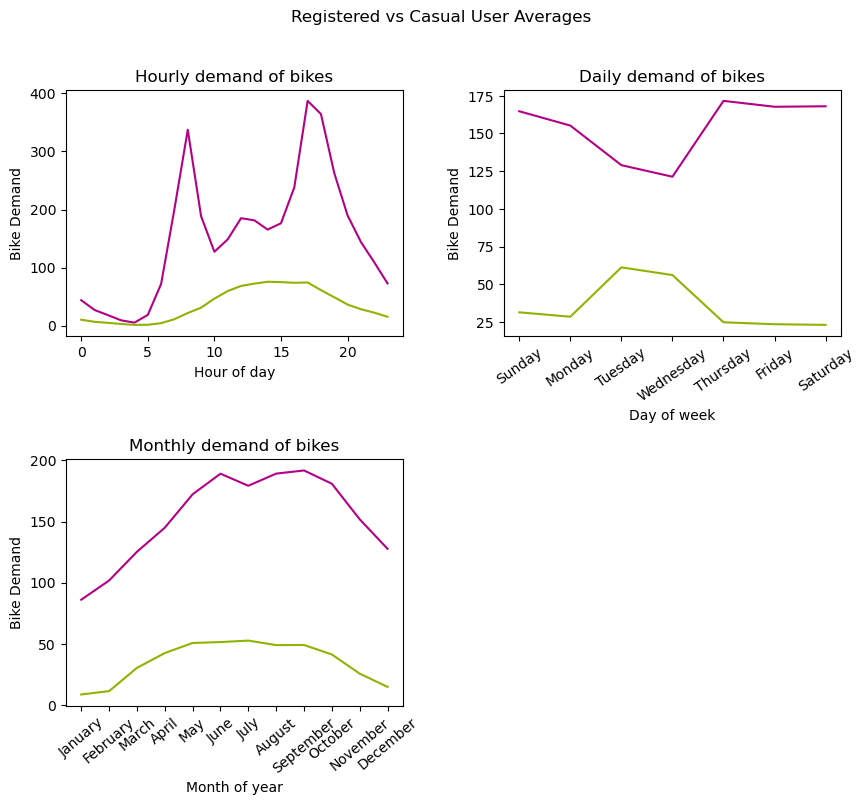

In [37]:
plt.figure(figsize=(10, 8))

plt.suptitle("Registered vs Casual User Averages")

plt.subplot(2,2,1)
plt.plot(hours, reg_hourly_data, color="#B30086")
plt.plot(hours, cas_hourly_data, color="#8FB300")
plt.xlabel("Hour of day")
plt.ylabel("Bike Demand")
plt.title("Hourly demand of bikes")
plt.subplot(2,2,2)
plt.plot(day_of_week, reg_daily_data, color="#B30086")
plt.plot(day_of_week, cas_daily_data, color="#8FB300")
plt.xlabel("Day of week")
plt.xticks(rotation=35)
plt.ylabel("Bike Demand")
plt.title("Daily demand of bikes")
plt.subplot(2,2,3)
plt.plot(months, reg_monthly_data, color="#B30086")
plt.plot(months, cas_monthly_data, color="#8FB300")
plt.xlabel("Month of year")
plt.xticks(rotation=40)
plt.ylabel("Bike Demand")
plt.title("Monthly demand of bikes")

plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()

#### Hourly demand:
The demand for bikes for both registered and casual on an hourly basis share a similar trend and are relatively steady. But it can be seen that casual users experience a peak around midday and experience a steady demand between the hours of 8:00 and 18:00. Registered users appear to have a greater number of fluctuations in bike demand but have more significant peak hours for demand.

#### Daily demand: 
We can see that registered users experience the highest demand on weekends with a decrease in demand Monday to Wednesday. We can suggest that registered users are more likely to use bikes for recreational purposes on the weekends. For casual users, we experience the highest demand between Monday and Wednesday. From this we can assume this is most likely related to commuting patterns for casual users.

#### Monthly demand: 
Based on the bike demand for registered and casual users, we can see that registered users have an increase in demand from January to June, then we experience a steady level of demand from May to September. From September, we can see a decrease in demand, which we can suggest is due to the drop in temperatures and weather conditions. For casual users, demand is also stable during most seasons, and similar to registered users we can see a decrease in demand during the winter months.


## Influence of weather on demand

In [40]:
weathersit_data = lyft_data.groupby("weathersit")["cnt"].mean()
weather_options = ["Clear", "Cloudy", "Light rain", "Heavy rain"]

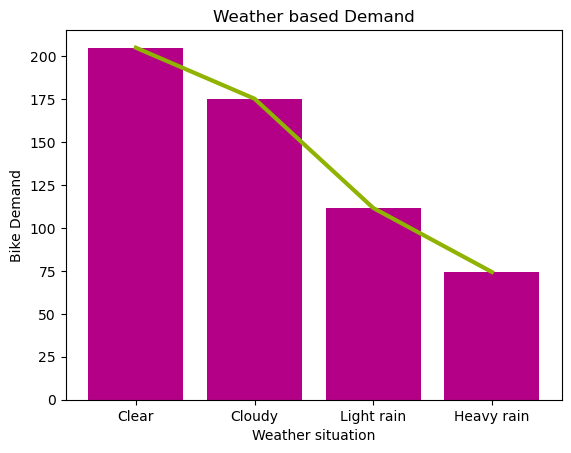

In [41]:
plt.bar(weather_options, weathersit_data, color="#B30086")
plt.plot(weather_options, weathersit_data, color="#8FB300", lw=3)
plt.xlabel("Weather situation")
plt.ylabel("Bike Demand")
plt.title("Weather based Demand")

plt.show()

Based on our graph, we can see that there is a clear negative trend as weather deteriorates. This is expected, as weather conditions are likely to be a deciding factor for users when choosing a mode of transport. We can suggest that cloudiness has a minimal impact on the bike demand, as demand is only reduced by 29, which is below our difference average of 43. Additionally, it can be seen that the greatest fall in demand occurs between "cloudy" and "light rain." From this, it can be suggested that rain may have a significant impact on bike demand.

## Predicting demand based on tempurature

#### Model 1: temp

In [45]:
x = lyft_data.temp*41
y = lyft_data.cnt
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:50:22   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0356      3.483     -0.010      0.9

The coefficient for our constant term (-0.0356) represents the predicted value of cnt when temp is zero. With a t-statistic of -0.01, it is clear that the constant value is statistically insignificant, thus has no meaningful contribution to explaining cnt.

Our coefficient for temp (9.2999) shows the marginal effect for changes in temp. For each additional increase in temp, demand for bikes increases by approximately 9. With a significance level of 0.05 (t = ±1.96), we can deduce that temp does have a significant impact on the demand of bikes (cnt).

In the regression summary, the R-squared value is 0.164. This represents the amount the independent variable (temp) explained by the variation in the dependent variable. Our R-squared value is 0.164, which represents a 16.4% variation in the demand caused by temperature.

#### Model 2: atemp

In [48]:
x = lyft_data.atemp*50
y = lyft_data.cnt
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3328.
Date:                Thu, 30 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:50:22   Log-Likelihood:            -1.1352e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.271e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8755      3.711     -3.200      0.0

The coefficient for our constant term (-11.8755) represents the predicted value of cnt when temp is zero. With a significance level of 0.05 (t = ±1.96), we can deduce that our constant term does have a significant impact on the demand of bikes (cnt).

Our coefficient for atemp (8.4636) shows the marginal effect for changes in atemp. For each additional increase in temp, demand for bikes increases by approximately 8. With a significance level of 0.05 (t = ±1.96), we can deduce that temp does have a significant impact on the demand of bikes (cnt).

In the regression summary, the R-squared value is 0.161. This represents the amount the independent variable (temp) explained by the variation in the dependent variable. Our R-squared value is 0.161, which represents a 16.1% variation in the demand caused by temperature.

### Summary of prediction models

Both Model 1 and Model 2 show that our regression analysis provide statistically significant estimations of bike demand, that can be used to help predict bike demand based on tempurature. With the ability to predict bike demand we are able to forecast the bike demand based on weekly tempuratures. This can allow for optimization of resources, ensuring bikes are available throughout the week to maintain customer satisfaction. Additionally, forecasting can allow dynamic pricing strategies to help maximize revenue by identifiying high demand periods. Overall, from these basic regression models we can help predict trends and forecast demand which can provide beneficial insights into demand. 